# Lunar Lander — Double DQN

2025, Artificial Intelligence, Sapienza.

*Enrique Favila Martínez.*

The purpose of this notebook is to train a **Double DQN** agent to solve Gymnasium's `LunarLander-v3`.

The notebook is structured for better understanding:
1. Set-up & imports  
2. Hyper-parameters (Feel free to tweak)  
3. Replay buffer  
4. Neural network  
5. Agent helpers (ε-greedy + optimisation)  
6. Evaluation  
7. Training loop & plotting  
8. Run training *and see how it learns*
9. Test the trained model on different scenarios and study it's behaviour



## What is a **Double Deep Q-Network**?

A **Double DQN** is a small—but powerful—upgrade to the original *Deep Q-Network (DQN)* that cures an optimism bug.

---

### The optimism bug in vanilla DQN
1. **Select & judge with the same brain**  
   *Plain DQN* uses **one** network to  
   `argmax_a Q_online(s', a)` **and** to evaluate that action.  
2. **Result → inflated Q-values**  
   By choosing *and* scoring, the network keeps rewarding its own mistakes, so estimates drift too high and learning can wobble.

---

### How Double DQN fixes it
| Role | Network | What it does |
|------|---------|--------------|
| **Action selector** | *Online (policy) net* | `a* ← argmax_a Q_online(s', a)` |
| **Action evaluator** | *Target net* (lagged copy) | `target = r + γ Q_target(s', a*)` |

*Two minds:*  
*One* picks the move, the *other* assigns the score → no self-flattery.

---

### Why we use it in Lunar Lander
* **Stabler learning curves** – fewer reward spikes & crashes.  
* **Better final scores** – ships typically “solve” (≥ 200 avg reward) faster.  
* **Negligible overhead** – just one extra forward pass per update.

> *Bottom line:* Double DQN lands the rocket sooner while keeping the code almost as simple as plain DQN.

## Install required packages
Swig is a library needed for Gymansium which is the environment that our agent use to learn, by reading the environment properties.

(*position, velocity, pad to land, ship legs, boosters; as a vector*)


In [ ]:
!pip install swig
!pip install "gymnasium[box2d]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp311-cp311-linux_x86_64.whl size=2379372 sha256=e4379997ca2752a9deafc29caaea7a00d1e4fc5a5c823cbe098e946b1ed5ef0e
  Stored in directory: /root/.cache/pip/wheels/ab/f1/0c/d56f4a2bdd12bae0a0693ec33f2f0daadb5eb9753c78fa5308
Successfully built box2d-py


In [ ]:

import random
from collections import deque, namedtuple
from dataclasses import dataclass
from pathlib import Path
from typing import List, Tuple

import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim


## Seed creation

### Why do we **set a random seed**?

Machine-learning runs can drift wildly if every source of randomness
(floats, shuffles, GPU kernels) changes each time.  
A **fixed seed** pins the dice rolls so you can debug, compare models,
and publish reproducible results.

---

### Where the randomness comes from
| Component | Typical calls | What it affects |
|-----------|---------------|-----------------|
| **Python `random`** | `random.random()` | ε-greedy action picks, buffer shuffles |
| **NumPy RNG** | `np.random.rand()` |  weight initialisation, batch sampling |
| **PyTorch RNG** | `torch.randn()` |  network weights, dropout, cuda ops |
| **cuDNN kernels** | GPU convolutions / GEMMs |  tiny numeric noise that can diverge |

---

### Seed setup used in the notebook
```python
def set_seed(seed=42):
    import random, numpy as np, torch
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark     = False


In [ ]:

# Reproducibility
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


## Hyper-parameters & what they control

| Name | Default | What it influences | Typical tuning range |
|------|---------|--------------------|----------------------|
| `episodes` | **1000** | Hard cap on how many training episodes we’ll run (early-stop can cut it short). | 400 – 3000 |
| `gamma` | **0.99** | Discount factor Γ – how far into the future rewards matter. Closer to 1 ➜ longer-term planning. | 0.95 – 0.999 |
| `lr` | **1e-3** | Adam learning-rate – size of each gradient step. Too high → divergence; too low → slow learning. | 1e-4 – 3e-3 |
| `batch_size` | **64** | Transitions drawn per optimiser step. Bigger batches smooth gradients but need more RAM. | 32 – 256 |
| `memory_capacity` | **100 000** | Max transitions stored in replay buffer. Larger = more diverse experience, slower sampling. | 50k – 500k |
| `start_learn_after` | **10 000** | Environment steps to collect **before** the first gradient update (lets the buffer fill). | 1k – 20k |
| `tau` | **5e-3** | Soft-update rate for target net (θ_target ← (1-τ)θ_target + τθ_policy). Smaller τ = stabler but slower. | 1e-3 – 1e-2 |
| `eps_start` | **1.0** | Initial ε for ε-greedy – start fully random to explore. | 0.9 – 1.0 |
| `eps_end` | **0.05** | Floor on ε – keeps a trickle of exploration forever. | 0.01 – 0.1 |
| `eps_decay` | **40 000** | Steps over which ε decays linearly from `eps_start` to `eps_end`. | 20k – 100k |
| `eval_every` | **50** | Episodes between evaluation runs (greedy, no learning). | 20 – 100 |
| `min_avg_score` | **200** | 100-episode moving-average reward that triggers early stopping (“solved” threshold). | 180 – 250 |

---

### Quick tuning tips

* **Learning stalls?** – raise `batch_size` or lower `lr`.  
* **Over-optimistic Q-values?** – decrease `tau` or try `gamma = 0.98`.  
* **Agent still exploring too much late in training?** – raise `eps_decay` or lower `eps_end`.  
* **Running out of RAM?** – cut `memory_capacity` in half; performance usually barely changes.

> *Remember:* most settings interact — tweak one knob at a time so you know which change helped.

Feel free to change hyperparameters to get different training results!

In [ ]:

@dataclass
class Config:
    episodes: int = 1000
    gamma: float = 0.99
    lr: float = 1e-3
    batch_size: int = 64
    memory_capacity: int = 100_000
    start_learn_after: int = 10_000
    tau: float = 5e-3
    eps_start: float = 1.0
    eps_end: float = 0.05
    eps_decay: int = 40_000
    eval_every: int = 50
    min_avg_score: float = 200


## What is a **Replay Buffer** (Experience Replay)?

A **replay buffer** is just a big circular list that stores every
(state, action, reward, next_state, done) tuple the agent experiences.
During learning we sample random mini-batches from it instead of using
*only the newest* transition.  
That single idea makes off-policy methods like DQN stable and data-efficient.

---

### Why bother storing old transitions?

| Problem without a buffer | How replay fixes it |
|--------------------------|---------------------|
| **Strong correlation** – consecutive frames are almost identical; SGD expects i.i.d. samples. | Random sampling breaks the correlation, giving cleaner gradient estimates. |
| **Catastrophic forgetting** – new experiences overwrite older, still-important states. | Mixing old & new keeps rare but critical transitions in play. |
| **Inefficient GPU use** – one frame → one update. | Bigger batches keep the GPU busy and amortise Python overhead. |

---

### The fields we keep

| Tuple element | Shape / dtype | Why we need it |
|---------------|---------------|----------------|
| `state`       | `np.float32[8]` | Starting observation for this step. |
| `action`      | `int`          | Which thruster command was chosen. |
| `reward`      | `float`        | Immediate scalar reward from the env. |
| `next_state`  | `np.float32[8]` | Observation **after** the action. |
| `done`        | `bool`         | `True` if episode has ended (crash or landing). |

---

### Key hyper-parameters

| Name in `Config` | Default | What it does |
|------------------|---------|--------------|
| `memory_capacity` | **100 000** | Max number of transitions kept; older ones drop off the back of the deque. |
| `batch_size`      | **64**       | How many transitions we draw per optimiser step. |
| `start_learn_after` | **10 000 steps** | Don’t sample until we have at least this many transitions — ensures batches are diverse. |

---

### How it plugs into training

```python
memory.push(state, action, reward, next_state, done)     # store new experience

if len(memory) >= cfg.start_learn_after:
    batch = memory.sample(cfg.batch_size)                # random mini-batch
    q_loss = compute_td_loss(batch)                      # optimise policy_net


In [ ]:

Transition = namedtuple("Transition", ("state", "action", "reward", "next_state", "done"))

class ReplayMemory:
    """Fixed‑size buffer that stores experience tuples."""
    def __init__(self, capacity: int):
        self.memory = deque(maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size: int):
        batch = random.sample(self.memory, batch_size)
        return Transition(*zip(*batch))

    def __len__(self):
        return len(self.memory)


### Neural network
## What is a **Deep Q-Network (DQN)?**

A **DQN** is the combination of two classic ideas:  
1. **Q-learning** – learn an action-value function *Q(s, a)* by bootstrapping.  
2. **Deep neural nets** – replace the tabular Q-table with a function approximator that works on continuous, high-dimensional states.

The network takes the current state (8 floats in Lunar Lander) and spits out **one Q-value per action** (4 thruster commands).  
During play we just pick `argmax_a Q(s, a)`; during training we update the weights so those Q-values satisfy the Bellman equation.

---

### One-cycle overview

| Step | What happens | Code hook in the notebook |
|------|--------------|---------------------------|
| ① Collect a transition | `(s, a, r, s', done)` goes into the replay buffer. | `memory.push(…)` |
| ② Sample a batch | Get *batch_size* random transitions. | `memory.sample(…)` |
| ③ Forward pass | `q_pred = policy_net(s).gather(a)` | inside `optimize_model` |
| ④ Build TD-target | `r + γ · max_a' Q_target(s', a')` (DQN) **or** the Double-DQN variant. | same place |
| ⑤ Back-prop | MSE / Huber loss → Adam step. | `optimizer.step()` |

---

### DQN **vs** Double DQN

| Aspect | **Plain DQN** | **Double DQN** |
|--------|---------------|----------------|
| Who picks *a′*? | `policy_net` | `policy_net` |
| Who evaluates *a′*? | **same** `policy_net` | **lagged** `target_net` |
| Result | Over-estimates → twitchy learning | Truer Q’s → smoother learning |

---


In [ ]:

class DQN(nn.Module):
    """Small MLP that outputs action‑values."""
    def __init__(self, obs_dim: int, act_dim: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, act_dim),
        )

    def forward(self, x):
        return self.net(x)



### Action-Selection & Optimisation helpers

These two utility functions turn static networks into a learning, exploring agent.

---

### 1  `select_action(state, policy_net, step, cfg, device)`

| Piece | Purpose |
|-------|---------|
| **ε-greedy rule** | Mixes exploration & exploitation:<br>`ε = ε_end + (ε_start − ε_end)·(1 − step / ε_decay)` → linearly decays from 1.0 to 0.05. |
| **Random branch** | With probability ε pick `random.randrange(n_actions)` to try unseen moves. |
| **Greedy branch** | Otherwise choose `argmax_a Q_policy(state, a)` via `policy_net(state)[0].argmax()`. |
| **Device-safe** | Converts NumPy → `torch.Tensor` and pushes to *CPU / GPU* automatically. |

> **Why it matters:** early on the agent needs to roam; later it should exploit what it has learned.  
> A linear schedule is simple, fast, and usually good enough for Lunar Lander.

---

### 2  `optimize_model(memory, policy_net, target_net, optimizer, cfg, device)`

| Stage | What happens | Code hint |
|-------|--------------|-----------|
| **Early-exit guard** | Skip if replay buffer < `start_learn_after` or `< batch_size`. | 2-line `return` shortcut |
| **Sample batch** | `state, action, reward, next_state, done = memory.sample(batch_size)` (random, i.i.d.). |
| **Forward pass** | `q_pred = policy_net(state).gather(1, action)` – predicted Q(s, a). |
| **Double-DQN target** | <code>a*  = argmax_a Q_policy(s', a)</code><br><code>q_next = Q_target(s', a*)</code><br>`target = r + γ·(1 − done)·q_next` |
| **Loss** | Smooth L1 (Huber) between `q_pred` and `target` – robust to outliers. |
| **Back-prop** | `loss.backward()` → `optimizer.step()` (Adam). |
| **Grad-clip** | `clip_grad_norm_(θ, 1.0)` tamps exploding gradients. |
| **Soft target update** | θ_target ← (1 − τ)·θ_target + τ·θ_policy (τ = 0.005) keeps the target net a slow-moving average. |

> **End result:** every time we call `optimize_model` the online network
> nudges its Q-values toward a less-biased Double-DQN target, and the
> target network drifts along quietly to provide fresh, stable labels next time.

---

### Quick tweaks you can try

* **Change exploration shape** – cosine or exponential decay instead of linear.  
* **Prioritised replay** – sample by TD-error, not uniform, for faster convergence.  
* **Soft-update rate (`τ`)** – smaller ⇒ stabler but slower; larger ⇒ faster but riskier.  
* **Gradient-clip value** – if you see exploding loss spikes, tighten from 1.0 to 0.5.

With these two helpers in place the rest of the training loop boils down to:

```python
action = select_action(state, policy_net, step, cfg, device)
next_state, reward, done, _, _ = env.step(action)
memory.push(state, action, reward, next_state, done)
optimize_model(memory, policy_net, target_net, optimizer, cfg, device)

In [ ]:

def select_action(state, policy_net, step, cfg, device):
    """ε‑greedy action selector with linear decay over *steps*."""
    eps = cfg.eps_end + (cfg.eps_start - cfg.eps_end) * max(0, (cfg.eps_decay - step)) / cfg.eps_decay
    if random.random() < eps:
        return random.randrange(policy_net.net[-1].out_features)
    with torch.no_grad():
        state_t = torch.as_tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        return int(policy_net(state_t).argmax(1).item())

def optimize_model(memory, policy_net, target_net, optimizer, cfg, device):
    if len(memory) < cfg.start_learn_after or len(memory) < cfg.batch_size:
        return

    batch = memory.sample(cfg.batch_size)
    state_b = torch.as_tensor(np.array(batch.state), dtype=torch.float32, device=device)
    action_b = torch.as_tensor(batch.action, dtype=torch.int64, device=device).unsqueeze(1)
    reward_b = torch.as_tensor(batch.reward, dtype=torch.float32, device=device).unsqueeze(1)
    next_state_b = torch.as_tensor(np.array(batch.next_state), dtype=torch.float32, device=device)
    done_b = torch.as_tensor(batch.done, dtype=torch.float32, device=device).unsqueeze(1)

    q_values = policy_net(state_b).gather(1, action_b)
    with torch.no_grad():
        next_actions = policy_net(next_state_b).argmax(1, keepdim=True)
        next_q = target_net(next_state_b).gather(1, next_actions)
        target = reward_b + cfg.gamma * (1.0 - done_b) * next_q

    criterion = nn.SmoothL1Loss()
    loss = criterion(q_values, target)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    nn.utils.clip_grad_norm_(policy_net.parameters(), 1.0)
    optimizer.step()

    # Soft target update
    with torch.no_grad():
        for pt, p in zip(target_net.parameters(), policy_net.parameters()):
            pt.data.mul_(1.0 - cfg.tau).add_(cfg.tau * p.data)



### Evaluation helper

Why keep evaluation separate
1.	**Noise-free metric** — no exploration randomness.
2.	**No side-effects** — weights & replay buffer stay untouched.
3.	**Early-stop trigger** — 100-episode moving average of these scores decides if we’ve “solved” the task (≥ 200).
4.	**Easy video capture** — wrap only the eval env in RecordVideo; training speed is unaffected.

In [ ]:

def evaluate_agent(env, policy_net, episodes=5, device=torch.device('cpu')):
    """Run policy greedily and return mean total reward."""
    scores = []
    for _ in range(episodes):
        state, _ = env.reset(seed=None)
        done = False
        total = 0.0
        while not done:
            with torch.no_grad():
                action = int(policy_net(torch.as_tensor(state, dtype=torch.float32, device=device)[None]).argmax(1).item())
            state, reward, done, trunc, _ = env.step(action)
            done = done or trunc
            total += reward
        scores.append(total)
    return float(np.mean(scores))


# Recording
This function handles the recording for human inspection.

Uses the best model available from the training, and will create a new video when there's a new evaluation in which the agent receives **at least 200+ reward score** compared to previous evaluation.

In [ ]:
# --- OPTIONAL: record evaluation runs as MP4s -------------------------------
import datetime
from gymnasium.wrappers import RecordVideo

def make_video_env():
    """Return a fresh env that records one episode to './videos/'."""
    timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    env = gym.make(
        "LunarLander-v3",
        render_mode="rgb_array",
    )
    return RecordVideo(
        env,
        video_folder="videos",
        name_prefix=f"lander_{timestamp}",
        episode_trigger=lambda ep: True,
    )

def record_greedy_episode(policy_net, device="cpu"):
    """Let the current policy land once and save the clip."""
    env = make_video_env()
    state, _ = env.reset(seed=None)
    done = False
    while not done:
        with torch.no_grad():
            action = int(
                policy_net(
                    torch.as_tensor(state, dtype=torch.float32, device=device)[None]
                ).argmax(1).item()
            )
        state, _, done, trunc, _ = env.step(action)
        done = done or trunc
    env.close()
    print("Saved a video to ./videos/")

### Training loop & plotting
Generates the plot for training history in terms of overall reward obtained on each episode.

In [ ]:

import matplotlib.pyplot as plt
from tqdm import trange

def _plot_curve(rewards):
    plt.plot(rewards)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Training progress')
    plt.grid(True)
    plt.show()

def train(cfg):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    env = gym.make('LunarLander-v3')
    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.n

    policy_net = DQN(obs_dim, act_dim).to(device)
    target_net = DQN(obs_dim, act_dim).to(device)
    target_net.load_state_dict(policy_net.state_dict())

    optimizer = optim.Adam(policy_net.parameters(), lr=cfg.lr)
    memory = ReplayMemory(cfg.memory_capacity)

    all_rewards = []
    best_score = -float('inf')
    step = 0

    for episode in trange(cfg.episodes, desc='Training', unit='ep'):
        state, _ = env.reset(seed=None)
        done = False
        total_reward = 0.0

        while not done:
            action = select_action(state, policy_net, step, cfg, device)
            next_state, reward, done, trunc, _ = env.step(action)
            finished = done or trunc
            memory.push(state, action, reward, next_state, finished)

            state = next_state
            total_reward += reward
            step += 1

            optimize_model(memory, policy_net, target_net, optimizer, cfg, device)

        all_rewards.append(total_reward)

        if (episode + 1) % cfg.eval_every == 0:
            avg = evaluate_agent(env, policy_net, device=device)
            if avg > best_score:
                best_score = avg
                torch.save(policy_net.state_dict(), 'best_model.pt')
                record_greedy_episode(policy_net, device)   # <-- add this
            print(f'\n[Eval] ep {episode+1:3d}: avg reward = {avg:.1f}')

            if len(all_rewards) >= 100 and np.mean(all_rewards[-100:]) >= cfg.min_avg_score:
                print('Solved! Average reward ≥ 200. Early stopping.')
                break

    torch.save(policy_net.state_dict(), 'final_model.pt')
    _plot_curve(all_rewards)
    env.close()


### Run training

1000 episodes takes ~30 minutes with Colab's T4

Training:  12%|█▏        | 62/500 [00:02<00:23, 18.45ep/s]

Saved a video to ./videos/

[Eval] ep  50: avg reward = -1263.7


Training:  20%|█▉        | 98/500 [00:03<00:09, 42.67ep/s]


[Eval] ep 100: avg reward = -1777.3


Training:  30%|██▉       | 149/500 [00:24<02:15,  2.58ep/s]/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
Training:  30%|███       | 150/500 [00:35<21:19,  3.66s/ep]

Saved a video to ./videos/

[Eval] ep 150: avg reward = -169.0


Training:  40%|████      | 200/500 [01:06<13:28,  2.70s/ep]


[Eval] ep 200: avg reward = -181.0


Training:  50%|█████     | 250/500 [04:02<09:35,  2.30s/ep]

Saved a video to ./videos/

[Eval] ep 250: avg reward = 11.3


Training:  60%|██████    | 300/500 [05:29<08:36,  2.58s/ep]

Saved a video to ./videos/

[Eval] ep 300: avg reward = 154.0


Training:  70%|███████   | 350/500 [06:42<06:19,  2.53s/ep]

Saved a video to ./videos/

[Eval] ep 350: avg reward = 221.1


Training:  80%|████████  | 400/500 [07:52<03:49,  2.30s/ep]


[Eval] ep 400: avg reward = 136.7


Training:  90%|█████████ | 450/500 [09:02<01:30,  1.82s/ep]


[Eval] ep 450: avg reward = 79.7


Training: 100%|██████████| 500/500 [10:11<00:00,  1.22s/ep]


[Eval] ep 500: avg reward = 160.8


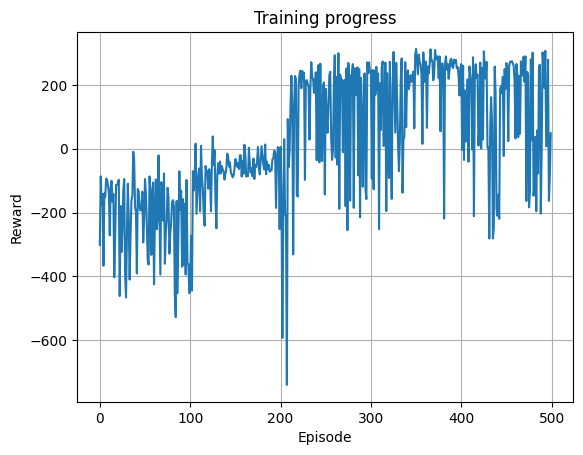

In [ ]:

set_seed()
cfg = Config()  # Feel free to tweak, e.g. Config(episodes=800, lr=5e-4)
train(cfg)


### Try the Run the new generated model!
Now that training it's over, our best model has been saved to our files as "best_model.pt". We can test it using `LunarLander-v3`.

You can change the *model_path* to the path of the best_model or final_model, the latter being the one used on the last training session.

It will store a new video in videos wit the prefix "*test_*"

In [15]:
# 1  Make a video env (RGB frames)
from gymnasium.wrappers import RecordVideo
import gymnasium as gym, torch, numpy as np
from pathlib import Path
from IPython.display import HTML

def record_episode(model_path="best_model.pt", fname_prefix="test_"):
    timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    env = RecordVideo(
        gym.make("LunarLander-v3", render_mode="rgb_array"),
        video_folder="videos",
        name_prefix=fname_prefix + timestamp,
        episode_trigger=lambda ep: True,     # record first (only) episode
    )

    obs_dim  = env.observation_space.shape[0]
    act_dim  = env.action_space.n
    device   = torch.device("cpu")

    policy = DQN(obs_dim, act_dim).to(device)
    policy.load_state_dict(torch.load(model_path, map_location=device))
    policy.eval()

    state, _ = env.reset()
    done = False
    while not done:
        with torch.no_grad():
            action = int(policy(torch.tensor(state, dtype=torch.float32)[None]).argmax())
        state, _, done, trunc, _ = env.step(action)
        done = done or trunc
    env.close()

    return sorted(Path("videos").glob(f"{fname_prefix}*.mp4"))[-1]   # newest clip

# 2️  Run it once
video_path = record_episode(model_path="best_model.pt")

print(f'Landing recorded as "{video_path}"')

/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Landing recorded as "videos/test_20250529-141440-episode-0.mp4"


In [16]:
def evaluate(agent, episodes=100):
    env = gym.make("LunarLander-v3")
    scores = []
    for _ in range(episodes):
        s,_ = env.reset()
        done = False; total = 0
        while not done:
            with torch.no_grad():
                a = int(agent(torch.tensor(s, dtype=torch.float32)[None]).argmax())
            s,r,done,trunc,_ = env.step(a)
            done = done or trunc
            total += r
        scores.append(total)
    env.close()
    return np.mean(scores), np.std(scores)

mean, std = evaluate(policy)
print(f"Average reward over 100 runs: {mean:.1f} ± {std:.1f}")

NameError: name 'policy' is not defined